# Desafío 1
## Equipo Lucia Sonnet - Micaela Kim - Dino Ronconi

In [1]:
import numpy as np
import pandas as pd
import geopandas
import shapely.wkt
from shapely.geometry import Point
import rtree
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
%matplotlib inline
import folium

### Cargamos en un dataframe los datos para el análisis, desde un archivo csv

In [2]:
properatti = pd.read_csv("properatti.csv")

## Exploración del dataframe
### Un primer vistazo a los datos

In [3]:
properatti.head(2)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


### Borramos dos columnas que consideramos inútiles para estos análisis

In [4]:
properatti.drop(['image_thumbnail', 'properati_url'], axis=1, inplace=True)

### Cambiamos los identificadores de las columnas por textos más intuitivos

In [5]:
 properatti.columns = ['id', 'tipo_oper', 'Tipo_prop', 'barrio',
       'lugar_completo', 'pais', 'provincia', 'geonames_id',
       'lat-lon', 'LAT', 'LNG', 'precio', 'moneda',
       'precio_moneda_local', 'precio_dolares', 'superficie',
       'superficie_cubierta', 'precio_x_m2_dolares', 'precio_x_m2','pisos',
       'ambientes', 'expensas', 'descripcion', 'titulo']

### Vemos las columnas con valores nulos

In [6]:
properatti.isna().sum()

id                     0
tipo_oper              0
Tipo_prop              0
barrio                23
lugar_completo         0
                   ...  
pisos             113321
ambientes          73830
expensas          106958
descripcion            2
titulo                 0
Length: 24, dtype: int64

### Vemos los distintos tipos de propiedad

In [7]:
properatti["Tipo_prop"].unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

### Chequeamos que todos los registros tengan el barrio

In [8]:
properatti[properatti["barrio"].isna()].head(3)

,id,tipo_oper,Tipo_prop,barrio,lugar_completo,pais,provincia,geonames_id,lat-lon,LAT,...,precio_dolares,superficie,superficie_cubierta,precio_x_m2_dolares,precio_x_m2,pisos,ambientes,expensas,descripcion,titulo
6489,6489,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4008968545,-58.63809847",-34.400897,...,650000.0,240.0,240.0,2708.333333,2708.333333,NaN,NaN,NaN,"Espectacular casa moderna de una planta, con a...",Venta de casa en Santa María de Tigre
10201,10201,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.400704,-58.638067",-34.400704,...,535000.0,NaN,300.0,NaN,1783.333333,NaN,5.0,NaN,Corredor Responsable: SABRINA COCCONI - CSI 62...,VENTA CASA SANTA MARÍA DE TIGRE COUNTRY BARRIO...
11451,11451,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026880384,-58.6262613379",-34.402688,...,550000.0,2170.0,270.0,253.456221,2037.037037,NaN,NaN,NaN,MUY LINDA CASA EN EXCELENTE UBICACION!! Superf...,SANTA MARIA DE TIGRE IMPECABLE


### Vemos que los faltantes son todos de Tigre, entonces los actualizamos directamente y comprobamos el resultado

In [9]:
properatti['barrio'].fillna('Tigre', inplace=True)
properatti.isna().sum()

id                     0
tipo_oper              0
Tipo_prop              0
barrio                 0
lugar_completo         0
                   ...  
pisos             113321
ambientes          73830
expensas          106958
descripcion            2
titulo                 0
Length: 24, dtype: int64

### Analizamos el precio promedio por barrio, para usarlo luego en los registros donde falta el precio.

####  falta agrupar por otras características, analizar si hay outliers, y en ese caso apartarlos

In [10]:

properatti.groupby('barrio')['precio_x_m2'].mean().head(5)

barrio
 Country Maschwitz Club    1303.311966
 los alamos                1990.243902
9 de Abril                  539.772727
Abasto                     2517.798880
Abril Club de Campo        1960.679121
Name: precio_x_m2, dtype: float64

#### (¿convendría unificar precio, moneda, para dejar de usar los otros campos con la misma info?). Vemos que hay precios en diversas modedas

In [13]:
properatti_temp['moneda'].unique()

NameError: name 'properatti_temp' is not defined

In [12]:
properatti.groupby('moneda')['moneda'].count()

moneda
ARS    13219
PEN        2
USD    87587
UYU        1
Name: moneda, dtype: int64

### Creamos un nuevo dataframe con sólo las columnas necesarias para el análisis de las columnas de precios

In [13]:
properatti_temp = properatti[['precio', 'moneda', 'precio_moneda_local', 'precio_dolares','superficie', 'superficie_cubierta','precio_x_m2_dolares','precio_x_m2']]
properatti_temp.isna()

,precio,moneda,precio_moneda_local,precio_dolares,superficie,superficie_cubierta,precio_x_m2_dolares,precio_x_m2
0,False,False,False,False,False,False,False,False
1,False,False,False,False,True,True,True,True
2,False,False,False,False,False,False,False,False
3,False,False,False,False,True,True,True,True
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
121215,False,False,False,False,False,False,False,False
121216,False,False,False,False,False,False,False,False
121217,False,False,False,False,False,False,False,False
121218,False,False,False,False,False,False,False,False


In [14]:
def completa_precios(dataf):
    for indice_fila, fila in dataf.iterrows():
        if (dataf.iloc[indice_fila,'precio_moneda_local']=='NaN') and (indice_fila < 100): #dataf['precio_x_m2'] is not NaN:
            print(indice_fila)
       

In [14]:
completa_precios(properatti_temp)

NameError: name 'completa_precios' is not defined

In [15]:
properatti_temp.iloc[4]['precio_moneda_local']=='NaN'

NameError: name 'properatti_temp' is not defined

In [16]:
precios = ['superficie_cubierta','precio_dolares','precio_x_m2_dolares']
properatti_temp[precios].isna().head(2)

NameError: name 'properatti_temp' is not defined

In [17]:


def from_x_y(df, x, y):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[Point(xy) for xy in zip(df[x], df[y])])
    return gdf


In [18]:
properatti_graf = properatti[0:len(properatti)]
properatti_graf.drop(properatti_graf.index[0:120000],inplace=True)

properatti_graf = from_x_y(properatti_graf, "LNG","LAT")
properatti_graf

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,id,tipo_oper,Tipo_prop,barrio,lugar_completo,pais,provincia,geonames_id,lat-lon,precio,...,superficie,superficie_cubierta,precio_x_m2_dolares,precio_x_m2,pisos,ambientes,expensas,descripcion,titulo,geometry
120000,120000,sell,PH,San Martín,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.569199,-58.5323996",90000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CODIGO: 1642-MAIPU ubicado en: BERNARDI - Pu...,VENTA DE PH 3 AMB CON TERRAZA EN VILLA MAIPU.,POINT (-58.53239960000001 -34.569199)
120001,120001,sell,house,Punilla,|Argentina|Córdoba|Punilla|,Argentina,Córdoba,3839996.0,"-31.4217232,-64.5124379",1700000.0,...,487.0,118.0,195.774641,14406.779661,NaN,NaN,NaN,CODIGO: 2015-CCP207 ubicado en: La Quinta - P...,"CCP207- Casa de 3 dormitorios y gran terreno, ...",POINT (-64.51243789999999 -31.4217232)
120002,120002,sell,apartment,Punilla,|Argentina|Córdoba|Punilla|,Argentina,Córdoba,3839996.0,"-31.415548,-64.5192216",1590000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CODIGO: 2015-EDF22 ubicado en: Centro - Publi...,EDF22- Imperdible oportunidad de tener tu depa...,POINT (-64.51922159999999 -31.415548)
120003,120003,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6494797,-58.5264097",122000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CODIGO: 1019-V350 ubicado en: RODRIGUEZ ALVES ...,"PH 2 AMBIENTES , CON PATIO , BALCON Y/O TERRAZ...",POINT (-58.52640970000001 -34.6494797)
120004,120004,sell,apartment,Punilla,|Argentina|Córdoba|Punilla|,Argentina,Córdoba,3839996.0,NaN,135000.0,...,65.0,NaN,2076.923077,NaN,NaN,NaN,NaN,CODIGO: 2015-DPT132 ubicado en: Jose Muñoz - ...,DPT132- Imperdible departamento lotf ubicado a...,POINT (nan nan)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121215,121215,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,NaN,870000.0,...,113.0,93.0,7699.115044,9354.838710,NaN,NaN,10000.0,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,POINT (nan nan)
121216,121216,sell,house,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3436080.0,NaN,498000.0,...,360.0,360.0,1383.333333,1383.333333,NaN,NaN,NaN,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,POINT (nan nan)
121217,121217,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,3433775.0,"-34.5706388726,-58.4755963355",131500.0,...,46.0,39.0,2858.695652,3371.794872,NaN,NaN,NaN,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,POINT (-58.4755963355 -34.5706388726)
121218,121218,sell,apartment,Plaza Colón,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,NaN,NaN,95900.0,...,48.0,48.0,1997.916667,1997.916667,NaN,NaN,NaN,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,POINT (nan nan)


In [19]:


m = folium.Map([-34.606359, -58.443863], zoom_start=12, tiles="OpenStreetMap")


In [20]:
#m = folium.Map([-42.606359, -55.443863], zoom_start=4.2, tiles="OpenStreetMap")
m = folium.Map([-34.606359, -58.443863], zoom_start=12, tiles="OpenStreetMap")
folium.GeoJson(properatti_graf.to_json()).add_to(m)


TypeError: '<=' not supported between instances of 'int' and 'str'

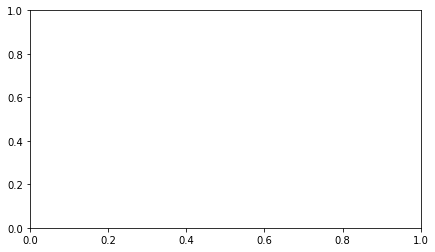

In [21]:
y = properatti_graf


plt.figure(figsize=(7, 4))
plt.hist(y, label=['1ro', '2do'], bins=25)
plt.grid(True)
plt.legend(loc=0)
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('Histograma');

In [23]:
y.head(2)

,id,tipo_oper,Tipo_prop,barrio,lugar_completo,pais,provincia,geonames_id,lat-lon,precio,...,superficie,superficie_cubierta,precio_x_m2_dolares,precio_x_m2,pisos,ambientes,expensas,descripcion,titulo,geometry
120000,120000,sell,PH,San Martín,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.569199,-58.5323996",90000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CODIGO: 1642-MAIPU ubicado en: BERNARDI - Pu...,VENTA DE PH 3 AMB CON TERRAZA EN VILLA MAIPU.,POINT (-58.53239960000001 -34.569199)
120001,120001,sell,house,Punilla,|Argentina|Córdoba|Punilla|,Argentina,Córdoba,3839996.0,"-31.4217232,-64.5124379",1700000.0,...,487.0,118.0,195.774641,14406.779661,NaN,NaN,NaN,CODIGO: 2015-CCP207 ubicado en: La Quinta - P...,"CCP207- Casa de 3 dormitorios y gran terreno, ...",POINT (-64.51243789999999 -31.4217232)


In [34]:
#SACAR LOS OUTLIERS

properatti.groupby('barrio')['precio_x_m2'].mean()
prop_x_precio = pd.qcut(properatti['precio_x_m2'], 10) 
prop_x_precio.head(5)

0    (1415.929, 1671.429]
1                     NaN
2    (1111.111, 1415.929]
3                     NaN
4    (1671.429, 1934.416]
Name: precio_x_m2, dtype: category
Categories (10, interval[float64]): [(1.5090000000000001, 1111.111] < (1111.111, 1415.929] < (1415.929, 1671.429] < (1671.429, 1934.416] ... (2560.0, 3021.633] < (3021.633, 3950.0] < (3950.0, 21111.111] < (21111.111, 3999999.96]]

In [25]:
properatti['lugar_completo'][0].find('|')

0

In [26]:
properatti['lugar_completo'].str.find('|')


0         0
1         0
2         0
3         0
4         0
         ..
121215    0
121216    0
121217    0
121218    0
121219    0
Name: lugar_completo, Length: 121220, dtype: int64

### Detectar y filtrar outliers
No existe un criterio que sea válido en todos los casos para identificar los outliers. El criterio de mayor que el tercer cuartil más 1.5 veces el rango intercuartil o menor que el primer cuartil menos 1.5 veces el rango intercuartil surge de la distribución normal. En esa distribución el 99.7% de la población se encuentra en el rango definido por la media (poblacional) más menos 3 veces el desvío estándar (poblacional)

In [ ]:
data.describe()

In [ ]:
np.random.seed(12345)
data = pd.DataFrame(np.random.randn(1000, 4))
data.sample(5)

In [ ]:
col = data[3]
col[np.abs(col) > 3]
#en este caso la media poblacional es 0 y el desvío es 1 entonces el criterio mencionado anteriormente 
# marcaría como outliers a los valores mayores que 3 o menores que -3
#col[np.abs(col) > 3 * np.std(col)]

In [ ]:
# Listamos aquellos que no son outliers
data[~(np.abs(data) > 3).any(axis=1)].head()

In [ ]:
len(data[~(np.abs(data) > 3).any(axis=1)])

In [ ]:
# Listamos las filas que tienen eleementos que están en los extremos de la distribución
data[(np.abs(data) > 3).any(1)]

# data.apply(lambda col:col[np.abs(col) > 3 * np.std(col)])

In [ ]:
# Acota el rango de la muestra
# Convierte los valores extremos a esos puntos de referencia
 
data[np.abs(data) > 3] = np.sign(data) * 3
data.describe()